LACOUX Coline <br/>
EL MADAFRITE Saad 

# Projet ML 2020 : Inpainting

In [45]:
%load_ext autoreload
%autoreload 2

from code_python.algorithms import *
from code_python.tools import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Partie 1 - Préambule : régression linéaire, régression ridge et LASSO

In [3]:
datax_train , datay_train = load_usps ("data/USPS_train.txt")
datax_test , datay_test = load_usps ("data/USPS_test.txt")

datay_train = np.where(datay_train > 1 , 1 , -1)
datay_test = np.where(datay_test > 1 , 1 , -1)

In [4]:
linear_reg_model = linear_model.LinearRegression()
linear_reg_model.fit(datax_train, datay_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
ridge_model = linear_model.RidgeCV()
ridge_model.fit(datax_train, datay_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [6]:
lasso_model = linear_model.LassoCV()
lasso_model.fit(datax_train, datay_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

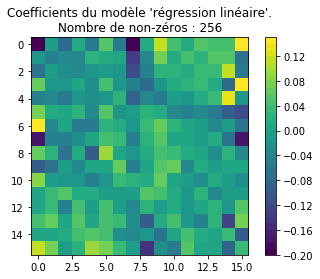

In [116]:
show_coefficients(linear_reg_model, "régression linéaire", save=True)

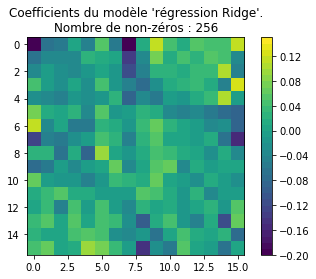

alpha choosen by CV : 10.0


In [117]:
show_coefficients(ridge_model, "régression Ridge", save=True)
print("alpha choosen by CV :", ridge_model.alpha_)

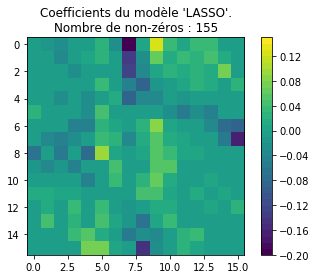

alpha choosen by CV : 0.0014177766311902348


In [118]:
show_coefficients(lasso_model, "LASSO", save=True)
print("alpha choosen by CV :", lasso_model.alpha_)


In [110]:
pred_train = np.sign(linear_reg_model.predict(datax_train)) 
pred_test = np.sign(linear_reg_model.predict(datax_test)) 

print("Linear regression accuracy on train : ",(pred_train == datay_train).mean())
print("Linear regression accuracy on test  : ",(pred_test  == datay_test).mean())

Linear regression accuracy on train :  0.9668083939103004
Linear regression accuracy on test  :  0.9446935724962631


In [466]:
pred_train = np.where(ridge_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(ridge_model.predict(datax_test) >= 0 , 1 , -1) 

print("Ridge regression accuracy on train : ",(pred_train == datay_train).mean())
print("Ridge regression accuracy on test  : ",(pred_test  == datay_test).mean())

Ridge regression accuracy on train :  0.967219860101495
Ridge regression accuracy on test  :  0.9441953163926258


In [467]:
pred_train = np.where(lasso_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(lasso_model.predict(datax_test) >= 0 , 1 , -1) 

print("Lasso algorithm accuracy on train : ",(pred_train == datay_train).mean())
print("Lasso algorithm accuracy on test  : ",(pred_test  == datay_test).mean())

Lasso algorithm accuracy on train :  0.9651625291455219
Lasso algorithm accuracy on test  :  0.9441953163926258


On remarque que la régression ridge permet de rapprocher de 0 certains coefficients, et ainsi de réduire l'impact de certains pixels dans la classification. LASSO effectue une sélection de features car des poids sont à 0 (seuls une partie des pixels est prise en comtpe dans la prédiction).

# Partie 2 - LASSO et Inpainting

## Test des outils de base

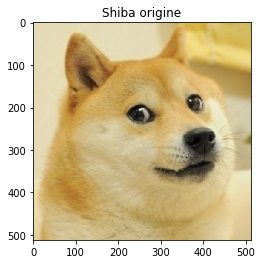

In [134]:
doge = read_img("data/doge.png")
show_img(doge, title="Shiba origine", save=True)

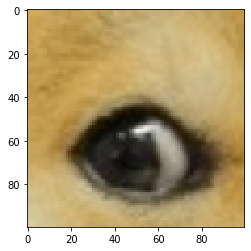

(100, 100, 3)


In [25]:
patch = get_patch(200,250, 100, doge)
show_img(patch)
print(patch.shape)

In [26]:
vect = patch_to_vect(patch)
print(vect.shape)

(30000,)


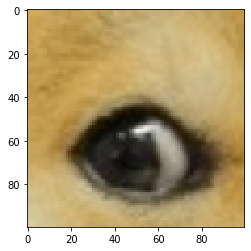

In [27]:
patch = vect_to_patch(vect)
show_img(patch)

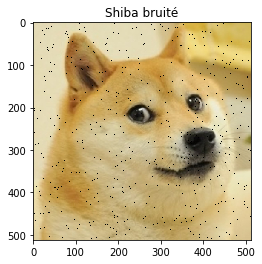

In [133]:
doge_noised = noise(doge, 0.01)
show_img(doge_noised, title="Shiba bruité", save=True)

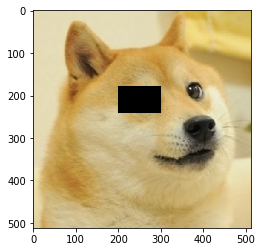

In [36]:
doge_pirate = delete_rect(doge, 210,250, 65,100)
show_img(doge_pirate)

In [38]:
dic = atoms_dictionary(doge_pirate, 100, 100)

In [39]:
print(len(dic))

14


In [41]:
missing_pixels = noise_dictionary(doge_pirate, 100, 100)
print(len(missing_pixels))

2


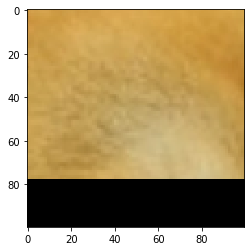

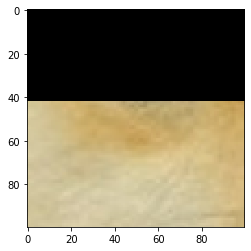

In [42]:
for patch in missing_pixels.values():
    show_img(patch)
    plt.show()

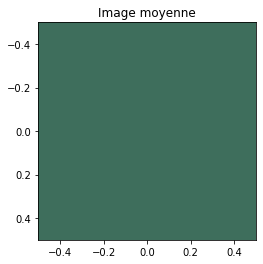

In [32]:
mean = np.mean(doge)
show_img([[[mean,mean,mean]]], title="Image moyenne", save=True)

## Test des algorithmes de reconstitution

### Naïve reconstruction

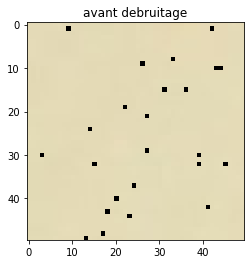

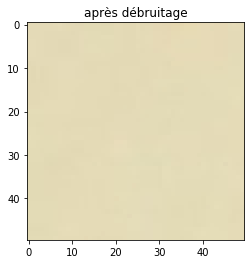

In [149]:
#essai sur un patch 
h = 50
missing_pixels = noise_dictionary(doge_noised, h, h)
dic = atoms_dictionary(doge,h, h)
for (i,j), patch in missing_pixels.items():
    w, new_patch = learn_weigth(patch, dic)
    show_img(patch, "avant debruitage", save=True)
    show_img(new_patch, "après débruitage", save=True)
    break

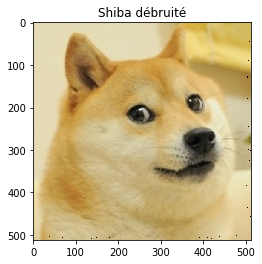

In [135]:
doge_denoised = naive_reconstruction(doge_noised, 20, 20)
show_img(doge_denoised, title="Shiba débruité", save=True)

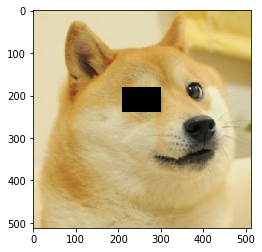

In [152]:
doge_reconstitued = naive_reconstruction(doge_pirate, 30, 30)
show_img(doge_reconstitued)

-> _naive_reconstruction_ : efficace pour reconstituer les textures bruitées mais pas les grandes zones manquantes.

### Onion peel algorithm

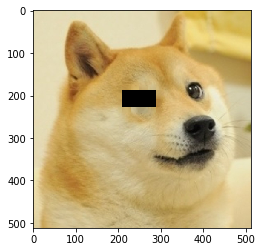

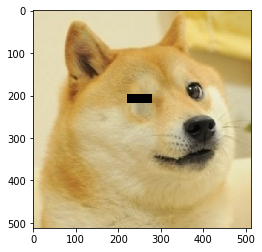

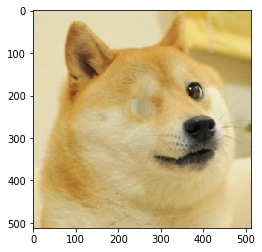

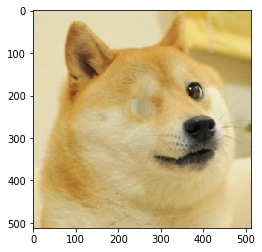

In [151]:
doge_borgne = onion_peel_reconstruction(doge_pirate, 20, 20, alpha='best', show=True)
show_img(doge_borgne)

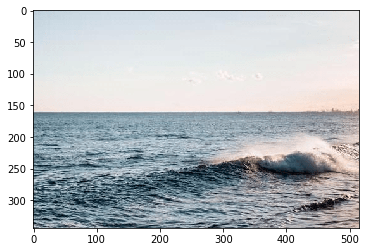

In [167]:
paysage = read_img("data/paysage.png")
show_img(paysage)

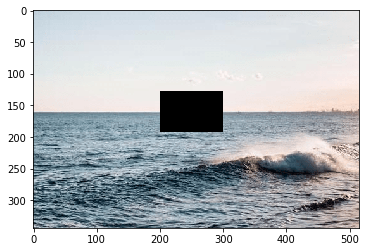

In [173]:
paysage_damaged = delete_rect(paysage,160,250, 65,100)
show_img(paysage_damaged)

/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035081650845528056, tolerance: 0.015290403240867423
  positive)


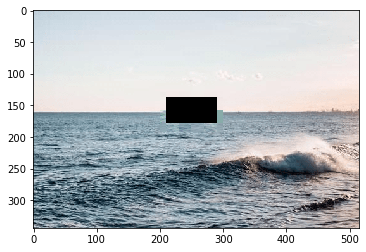

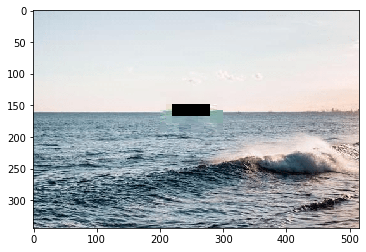

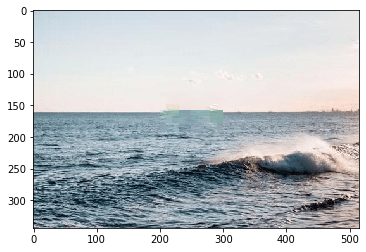

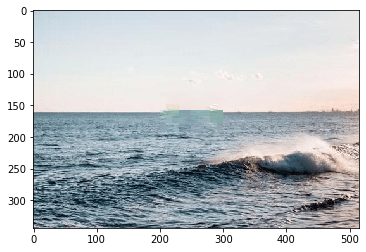

In [176]:
paysage_reconstruit_oignon = onion_peel_reconstruction(paysage_damaged, 20, 20, alpha='best', show=True)
show_img(paysage_reconstruit_oignon)

In [ ]:
paysage_reconstruit_oignon = onion_peel_reconstruction(paysage_damaged, 14, 14, alpha='best', show=True)
show_img(paysage_reconstruit_oignon)

/Users/colinelacoux/Desktop/ML/ML/Projet Inpainting/code_python/tools.py:167: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X[train_i], Y[train_i])
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/colinelacoux/Desktop/ML/ML/Projet Inpainting/code_python/tools.py:167: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X[train_i], Y[train_i])
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/colinelacoux/Desktop/ML/ML/Projet Inpainting/code_python/tool

/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04943175667829616, tolerance: 0.00821405322277737
  positive)
/Users/colinelacoux/Desktop/ML/ML/Projet Inpainting/code_python/tools.py:167: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X[train_i], Y[train_i])
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6686414792585783, tolera

/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4026629070766536, tolerance: 0.019072690130139035
  positive)
/Users/colinelacoux/Desktop/ML/ML/Projet Inpainting/code_python/tools.py:167: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X[train_i], Y[train_i])
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1562783798985534, tolera

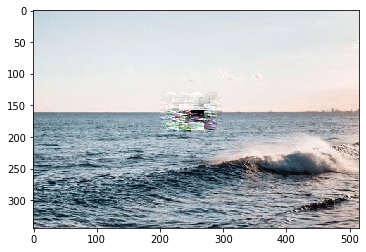

In [178]:
paysage_reconstruit_oignon = onion_peel_reconstruction(paysage_damaged, 20, 20, alpha=0)
show_img(paysage_reconstruit_oignon)

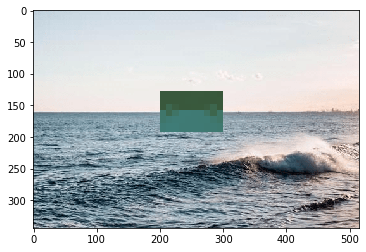

In [179]:
paysage_reconstruit_oignon = onion_peel_reconstruction(paysage_damaged, 20, 20, alpha=1)
show_img(paysage_reconstruit_oignon)

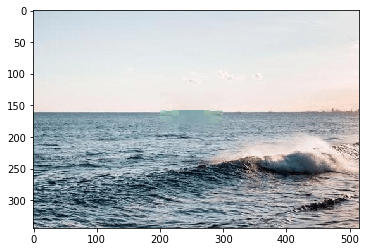

In [180]:
paysage_reconstruit_oignon = onion_peel_reconstruction(paysage_damaged, 20, 20, alpha=0.005)
show_img(paysage_reconstruit_oignon)

-> efficace sur grandes zone mais d'une même texture, bordures pas ouf


-> pas suffisant si plusieurs textures dans la partie manquante (variation de couleurs)

    TODO : implémenter des statégie d'ordre de remplissage (voir article 3):
    - stratégie "onion peel" : commence par remplir en partant des bords (patch avant du bruit mais aussi des valeurs présents (+ d'un tiers par ex) mettre à jour le dict puis recommencer puis en remplissant au fur et à mesure vers le centre de l’image
    - implémenter heuristique proposée dans l'article 3

si alpha trop grand : aucun patch est pris en compte, l'algo remplace dc tous les pixels par une valeur moyenne (moyenne de l'image applatie)

In [ ]:
doge_oignon = onion_peel_reconstruction(doge_rectangle, 20, alpha='best', s)
show_img(doge_oignon)

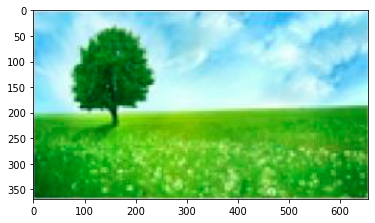

In [115]:
paysage = read_img("data/paysage.png")
show_img(paysage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


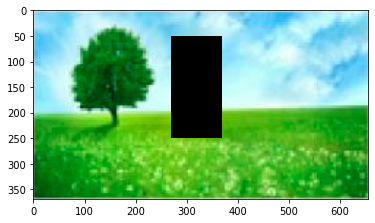

In [116]:
paysage_damaged = delete_rect(paysage, 150,320, 200,100)

show_img(paysage_damaged)

limite : plus alpha diminue, plus le nm d'itérations nécessaires est grand donc plus l'ago est long

idée del l'article 3 : on remplit en priorité les patch ayant des couleurs disperdées (bordures)

TODO : priority du patch  = confidence * data term

confidence = nb de pixels exprimés dans le patch
data term modifié à chaque itération. he data term gives high priority to pixels on the continuation of image structures -> pour simplifier, on verra ça comme un indicateur de la diversité des couleurs dans l'image (somme des écarts à la moyenne pour chaque canal). pas idéale si par ex l'image contient une texture contenant des couleurs variées

traiter les bordures en priorité pour essayer de préserver les structures

In [ ]:
def compute_data_term(patch):
    

In [ ]:
def dictionary_priority(img, x, y, m, n, h):
    dic = {}
    for i in range(x, x+m+h, h):
        for j in range(y, y+n+h, h):
            patch = get_patch(i, j, h, img)
            confidence = pa
            data_term = compute_data_term(patch)
            prior = confidence * data_term
            if miss_pixel(patch):
                dic[prior] = [patch, i, j, confidence, data_term]
    return dic

In [ ]:
def preserve_structures_reconstruction(img, h, step, alpha=0.005):
    damaged_zone = missing_pixels = np.argwhere(img == -100)
    img_rec = img.copy()
    dic = atoms_dictionary(img, h, step)
    stop = False
    damaged_dic = 
    while not stop :
        centered_dic = initialize_peel(img_rec, h)
        stop = True
        for (i,j), patch in centered_dic.items():
            if not empty_patch(patch):
                w, new_patch = learn_weigth(patch, dic, alpha)
                replace_patch(img_rec, new_patch, i, j, h)
            else:
                stop = False # un patch n'a pas pu être traité donc on continue
        show_img(img_rec)
        dic= atoms_dictionary(img_rec, h)
    return img_rec